In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
!hostname
!pwd

dv001.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023


In [3]:
import sys, os
import numpy as np
import pandas as pd

sys.path.append('..')
%aimport mre_pinn

sys.path.append('../../param_search')
%aimport param_search
ps = param_search

Using backend: pytorch



# MICCAI 2023 patient experiment

In [3]:
%pwd

'/ocean/projects/asc170022p/mtragoza/mre-pinn/MICCAI-2023'

In [74]:
template = '''\
#!/bin/bash
#SBATCH --job-name={job_name}
#SBATCH --account=asc170022p
#SBATCH --partition=GPU-shared
#SBATCH --gres=gpu:1
#SBATCH -x v034
#SBATCH --time=48:00:00
#SBATCH -o %J.stdout
#SBATCH -e %J.stderr
#SBATCH --mail-type=all

hostname
pwd
module load anaconda3
conda activate /ocean/projects/asc170022p/mtragoza/mambaforge/envs/MRE-PINN

python ../../../train.py \\
    --xarray_dir {xarray_dir} \\
    --example_id {example_id} \\
    --frequency {frequency} \\
    --noise_ratio {noise_ratio} \\
    --omega {omega} \\
    --polar_input {polar_input} \\
    --savgol_filter {savgol_filter} \\
    --pde_name {pde_name} \\
    --pde_warmup_iters 10000 \\
    --pde_step_iters 5000 \\
    --pde_step_factor 10 \\
    --pde_init_weight {pde_init_weight} \\
    --pde_loss_weight {pde_loss_weight} \\
    --a_loss_weight {a_loss_weight} \\
    --anatomical {anatomical} \\
    --n_iters {n_iters} \\
    --save_prefix {job_name}    
'''
name = 'train_{data_name}_{example_id}_{omega}_{pde_name}_{a_loss_weight:.0e}'

param_space = ps.ParamSpace(
    pde_name=['hetero'],
    a_loss_weight=[0, 1, 1e-2, 1e-4], # 1e-1, 1e-3],
    data_name='patient',
    xarray_dir='../../../data/NAFLD/v4',
    example_id=['0006', '0020', '0024', '0029', '0043', '0047', '0126', '0135', '0155', '0164', '0172', '0173', '0210', '0213', '0219', '0222', '0234', '0235', '0291', '0344', '0378', '0384', '0395', '0401', '0415', '0457', '0461', '0491', '0492', '0496', '0509', '0510', '0516', '0525', '0564', '0604', '0612', '0615', '0628', '0639', '0648', '0650', '0653', '0655', '0659', '0693', '0704', '0717', '0727', '0734', '0737', '0740', '0747', '0748', '0898', '0900', '0929', '0931', '0932', '0940', '0954', '0964', '0965', '0979', '0989', '0995', '1028', '1033', '1039', '1045', '1075', '1076', '1077', '1083', '1103', '1106', '1108', '1110', '1119', '1121', '1123', '1134', '1144', '1149', '1205', '1207', '1215', '1217', '1230', '1261', '1271', '1296', '1303', '1311', '1329', '1337', '1341', '1343', '1344', '1382', '1395', '1400', '1404', '1417', '1426', '1427', '1433', '1435', '1448', '1453', '1456', '1464', '1671', '1679', '1694', '1699', '1706', '1712', '1714', '1715', '1720', '1722', '1727', '1736', '1748', '1785', '1786', '1790', '1791', '1793', '1795', '1798', '1806', '1807', '1819', '1829', '1839', '1843', '1851', '1853', '1896', '1899', '1903', '1917', '1935', '1940', '1948', '1967', '1979', '1980', '2001', '2007', '2029', '2034', '2046'],
    frequency=40,
    noise_ratio=0.0,
    omega=[30],
    polar_input=1,
    savgol_filter=[0],
    pde_init_weight=1e-18,
    pde_loss_weight=1e-16,
    anatomical=True,
    n_iters=100000,
)

len(param_space)

620

In [75]:
for p in list(param_space)[:24]:
    print(name.format(**p))

train_patient_0006_30_hetero_0e+00
train_patient_0020_30_hetero_0e+00
train_patient_0024_30_hetero_0e+00
train_patient_0029_30_hetero_0e+00
train_patient_0043_30_hetero_0e+00
train_patient_0047_30_hetero_0e+00
train_patient_0126_30_hetero_0e+00
train_patient_0135_30_hetero_0e+00
train_patient_0155_30_hetero_0e+00
train_patient_0164_30_hetero_0e+00
train_patient_0172_30_hetero_0e+00
train_patient_0173_30_hetero_0e+00
train_patient_0210_30_hetero_0e+00
train_patient_0213_30_hetero_0e+00
train_patient_0219_30_hetero_0e+00
train_patient_0222_30_hetero_0e+00
train_patient_0234_30_hetero_0e+00
train_patient_0235_30_hetero_0e+00
train_patient_0291_30_hetero_0e+00
train_patient_0344_30_hetero_0e+00
train_patient_0378_30_hetero_0e+00
train_patient_0384_30_hetero_0e+00
train_patient_0395_30_hetero_0e+00
train_patient_0401_30_hetero_0e+00


In [4]:
%autoreload

expt_names = [
    '2023-2-16_patient_anat',  # a_loss_weight
    '2023-2-18_patient_anat',  # move queued jobs to GPU-shared
    '2023-2-20_patient_anat2', # expanded a_loss_weight range
    '2023-2-26_patient_FEM',   # just the new FEM baselines
    '2023-2-28_patient_anat3', # fix v034 errors- Helmholtz
    '2023-3-2_patient_anat',   # fix v034 errors- hetero
]
expt_name = expt_names[-1]

#jobs = ps.submit(template, name, list(param_space), work_dir=expt_name, verbose=True)
#jobs.to_csv(f'{expt_name}.jobs')

#jobs = pd.concat([pd.read_csv(f'{e}.jobs', index_col=0) for e in expt_names])
jobs = pd.read_csv(f'{expt_name}.jobs', index_col=0)

jobs

,pde_name,a_loss_weight,data_name,xarray_dir,example_id,frequency,noise_ratio,omega,polar_input,savgol_filter,...,anatomical,n_iters,job_name,job_id,partition,job_state,node_id,runtime,work_dir,array_idx
0,hetero,0.0000,patient,../../../data/NAFLD/v4,6,40,0.0,30,1,0,...,True,100000,train_patient_0006_30_hetero_0e+00,14776959,GPU-shared,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
1,hetero,0.0000,patient,../../../data/NAFLD/v4,20,40,0.0,30,1,0,...,True,100000,train_patient_0020_30_hetero_0e+00,14776960,GPU-shared,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
2,hetero,0.0000,patient,../../../data/NAFLD/v4,24,40,0.0,30,1,0,...,True,100000,train_patient_0024_30_hetero_0e+00,14776961,GPU-shared,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
3,hetero,0.0000,patient,../../../data/NAFLD/v4,29,40,0.0,30,1,0,...,True,100000,train_patient_0029_30_hetero_0e+00,14776962,GPU-shared,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
4,hetero,0.0000,patient,../../../data/NAFLD/v4,43,40,0.0,30,1,0,...,True,100000,train_patient_0043_30_hetero_0e+00,14776963,GPU-shared,PENDING,(Priority),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615,hetero,0.0001,patient,../../../data/NAFLD/v4,2001,40,0.0,30,1,0,...,True,100000,train_patient_2001_30_hetero_1e-04,14777574,GPU-shared,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
616,hetero,0.0001,patient,../../../data/NAFLD/v4,2007,40,0.0,30,1,0,...,True,100000,train_patient_2007_30_hetero_1e-04,14777575,GPU-shared,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
617,hetero,0.0001,patient,../../../data/NAFLD/v4,2029,40,0.0,30,1,0,...,True,100000,train_patient_2029_30_hetero_1e-04,14777576,GPU-shared,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN
618,hetero,0.0001,patient,../../../data/NAFLD/v4,2034,40,0.0,30,1,0,...,True,100000,train_patient_2034_30_hetero_1e-04,14777577,GPU-shared,PENDING,(None),0:00,/ocean/projects/asc170022p/mtragoza/mre-pinn/M...,NaN


In [5]:
%autoreload
status_cols = ['job_name', 'job_state', 'node_id', 'runtime', 'stdout', 'stderr']
status = ps.status(jobs, parse_stdout=True, parse_stderr=True)
status[status_cols]

,job_name,job_state,node_id,runtime,stdout,stderr
job_id,,,,,,
14776959,train_patient_0006_30_hetero_0e+00,NaN,NaN,NaN,v023,
14776960,train_patient_0020_30_hetero_0e+00,NaN,NaN,NaN,v023,
14776961,train_patient_0024_30_hetero_0e+00,NaN,NaN,NaN,v023,
14776962,train_patient_0029_30_hetero_0e+00,NaN,NaN,NaN,v021,
14776963,train_patient_0043_30_hetero_0e+00,NaN,NaN,NaN,v021,
...,...,...,...,...,...,...
14777574,train_patient_2001_30_hetero_1e-04,NaN,NaN,NaN,v019,
14777575,train_patient_2007_30_hetero_1e-04,NaN,NaN,NaN,v022,
14777576,train_patient_2029_30_hetero_1e-04,NaN,NaN,NaN,v024,


In [6]:
def get_error_type(e):
    for error_type in [
        'CANCELLED',
        'python: command not found',
        'Unexpected error from cudaGetDeviceCount()'
    ]:
        if error_type in e:
            return error_type
    return e

status['has_stderr_file'] = status.stderr.map(lambda x: not (isinstance(x, float) and np.isnan(x)))
status['has_stderr'] = ~status.stderr.isnull() & ~(status.stderr == '')
status['error'] = status.stderr.astype(str).map(get_error_type)

status.fillna('DONE').groupby(['job_state', 'has_stderr_file', 'has_stderr', 'error'])[['job_name']].count()

job_name
job_state has_stderr_file has_stderr error                              
DONE      True            False                                      619
                          True       python: command not found         1

In [7]:
status[status.has_stderr].groupby(['error', 'stdout'])[['job_name']].count()

,,job_name
error,stdout,
python: command not found,v027,1


In [8]:
jobs = pd.concat([
    pd.read_csv(f'2023-2-28_patient_anat3.jobs', index_col=0), # helmholtz
    pd.read_csv(f'2023-3-2_patient_anat.jobs', index_col=0),   # hetero
])
metrics = ps.metrics(jobs)

train_patient_1261_30_helmholtz_1e+00 No objects to concatenate
train_patient_1785_30_helmholtz_1e+00 No objects to concatenate
train_patient_1786_30_helmholtz_1e+00 No objects to concatenate
train_patient_1790_30_helmholtz_1e+00 No objects to concatenate
train_patient_1791_30_helmholtz_1e+00 No objects to concatenate
train_patient_0384_30_helmholtz_1e-02 No objects to concatenate
train_patient_0509_30_helmholtz_1e-04 No objects to concatenate
train_patient_0043_30_hetero_1e-04 No objects to concatenate


In [9]:
param_cols = ['pde_name', 'example_id', 'omega', 'a_loss_weight', 'savgol_filter'] # experimental parameters
index_cols = ['variable_name', 'spatial_frequency_bin', 'spatial_region'] # metric identifiers
metric_cols = ['MSAV', 'PSD', 'MAV', 'R'] # metric values

def metric_map(tup):
    metric_name, var_name = tup
    new_col_name = f'{var_name}_{metric_name}'
    new_col_name = new_col_name.replace('diff_MSAV', 'pred_MSAE')
    new_col_name = new_col_name.replace('pde_diff_MSAV', 'PDE_MSAE')
    new_col_name = new_col_name.replace('diff_MAV', 'pred_MAD')
    return new_col_name

def format_metrics(metrics):
    metrics = metrics[metrics.iteration == 100e3]
    metrics = metrics.groupby(param_cols + index_cols, sort=False)[metric_cols].mean()
    metrics = metrics.unstack(level=[len(param_cols)])
    metrics.columns = [metric_map(t) for t in metrics.columns.to_flat_index()]
    return metrics
    
metrics = format_metrics(metrics)
metrics

a_pred_MSAV  \
pde_name  example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                 
helmholtz 6          30    0.0000        0             all                   all             31189.904757   
                                                                             0.0                      NaN   
                                                                             1.0                      NaN   
                                                       1.0                   all                      NaN   
                                                       2.0                   all                      NaN   
...                                                                                                   ...   
hetero    2046       30    0.0001        0             6.0                   all                      NaN   
                                                       7.0                   all                      NaN   
                                                       8.0                   all                      NaN   
                                                       9.0                   all                      NaN   
                                                       10.0                  all                      NaN   

                                                                                              a_pred_MSAE  \
pde_name  example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                 
helmholtz 6          30    0.0000        0             all                   all             26128.545977   
                                                                             0.0                      NaN   
                                                                             1.0                      NaN   
                                                       1.0                   all                      NaN   
                                                       2.0                   all                      NaN   
...                                                                                                   ...   
hetero    2046       30    0.0001        0             6.0                   all                      NaN   
                                                       7.0                   all                      NaN   
                                                       8.0                   all                      NaN   
                                                       9.0                   all                      NaN   
                                                       10.0                  all                      NaN   

                                                                                              a_true_MSAV  \
pde_name  example_id omega a_loss_weight savgol_filter spatial_frequency_bin spatial_region                 
helmholtz 6          30    0.0000        0             all                   all             19750.975778   
                                                                             0.0                      NaN   
                                                                             1.0                      NaN   
                                                       1.0                   all                      NaN   
                                                       2.0                   all                      NaN   
...                                                                                                   ...   
hetero    2046       30    0.0001        0             6.0                   all                      NaN   
                                                       7.0                   all                      NaN   
                                                       8.0                   all                      NaN   
                                                       9.0 

<IPython.core.display.Javascript object>


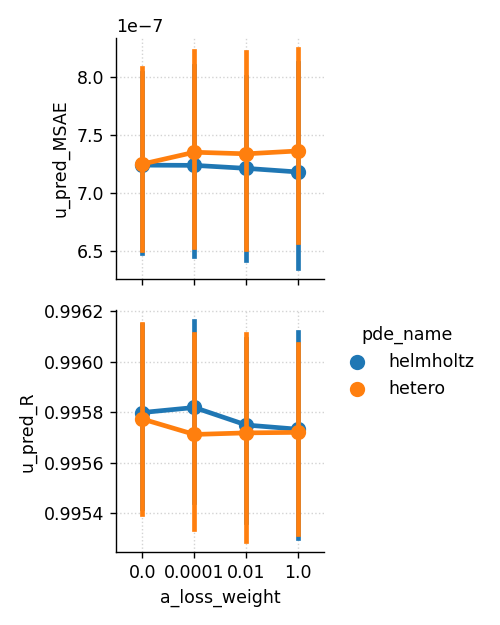

In [10]:
m = metrics.reset_index()

fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')],
    x=['a_loss_weight'],
    y=['u_pred_MSAE', 'u_pred_R'],
    hue='pde_name',
    height=2.5,
    width=4,
    legend=True,
    tight=True
)

<IPython.core.display.Javascript object>


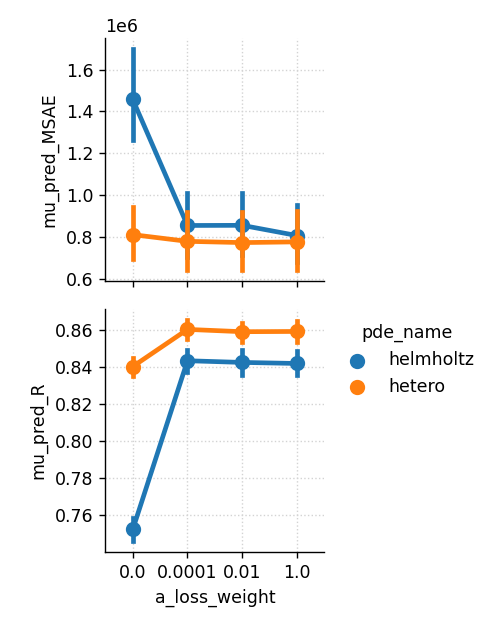

In [11]:
fig = ps.plot(
    m[(m.spatial_region == 'all') & (m.spatial_frequency_bin == 'all')],
    x=['a_loss_weight'],
    y=['mu_pred_MSAE', 'mu_pred_R'],
    hue='pde_name',
    height=2.5,
    width=4,
    legend=True,
    tight=True
)

In [12]:
m['pde_abbrev'] = m.pde_name.map({'helmholtz': 'HH', 'hetero': 'het'}.__getitem__)
m['method'] = 'PINN-' + m['pde_abbrev']

ahi_m = m[m.pde_name == 'helmholtz'].copy()
ahi_m['method'] = 'AHI'
for col in m.columns:
    if col.startswith('direct'):
        ahi_m[col.replace('direct', 'mu')] = m[col]
        
fem_m = m.copy()
fem_m['method'] = 'FEM-' + m['pde_abbrev']
for col in m.columns:
    if col.startswith('fem'):
        fem_m[col.replace('fem', 'mu')] = m[col]
        
mm = pd.concat([ahi_m, fem_m, m])

method_order = ['AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het']
mm['method_index'] = mm['method'].map(method_order.index)
mm = mm.sort_values('method_index')

In [13]:
import matplotlib as mpl
pct_format = mpl.ticker.PercentFormatter()

mm['mu_pred_MSAE_relative'] = mm['mu_pred_MSAE'] / mm['mu_true_MSAV'] * 100
mm['mu_pred_MAD_relative']  = mm['mu_pred_MAD']  / mm['mu_true_MAV'] * 100

In [14]:
%autoreload
import seaborn as sns
import matplotlib.pyplot as plt

colors = ps.results.get_color_palette(10, type='deep', min_val=0)
blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = colors

colors = [blue, yellow, red, cyan, green]
sns.set_palette(colors)
colors = sns.color_palette()
colors

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)]

In [15]:
mm.spatial_region.unique()

array(['all', '1.0', '0.0'], dtype=object)

<IPython.core.display.Javascript object>


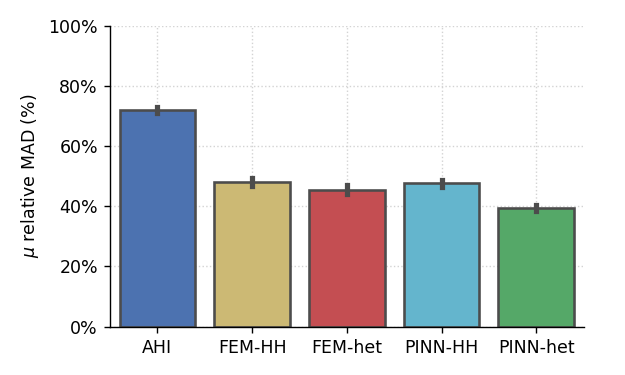

In [16]:
fig = ps.plot(
    mm[(mm.spatial_region == '1.0') & (mm.a_loss_weight == 0.0)].copy(),
    x='method',
    y='mu_pred_MAD_relative',
    height=3,
    width=5,
    legend=True,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_xlabel(None)
fig.axes[0].set_ylabel('$\mu$ relative MAD (%)')
fig.axes[0].set_ylim(0, 100)
fig.axes[0].yaxis.set_major_formatter(pct_format)
fig.tight_layout()

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])   

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_method_MAD_bar_plot.{ext}', bbox_inches='tight', dpi=200)

<IPython.core.display.Javascript object>


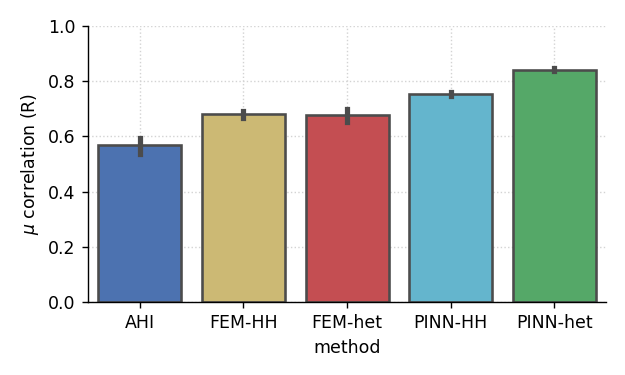

In [17]:
fig = ps.plot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all') & (mm.a_loss_weight == 0.0)].copy(),
    x='method',
    hue='method',
    y='mu_pred_R',
    height=3,
    width=5,
    legend=False,
    tight=True,
    plot_func=ps.results.barplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_ylim([0, 1])
fig.tight_layout()

for i, patch in enumerate(fig.axes[0].patches):
    plt.setp(patch, facecolor=colors[i])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_method_R_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [18]:
mm['a_loss_weight_mod'] = mm['a_loss_weight'].copy()
mm.loc[mm.a_loss_weight == 0, 'a_loss_weight_mod'] = 1e-8 # for log-scale plotting purposes

<IPython.core.display.Javascript object>


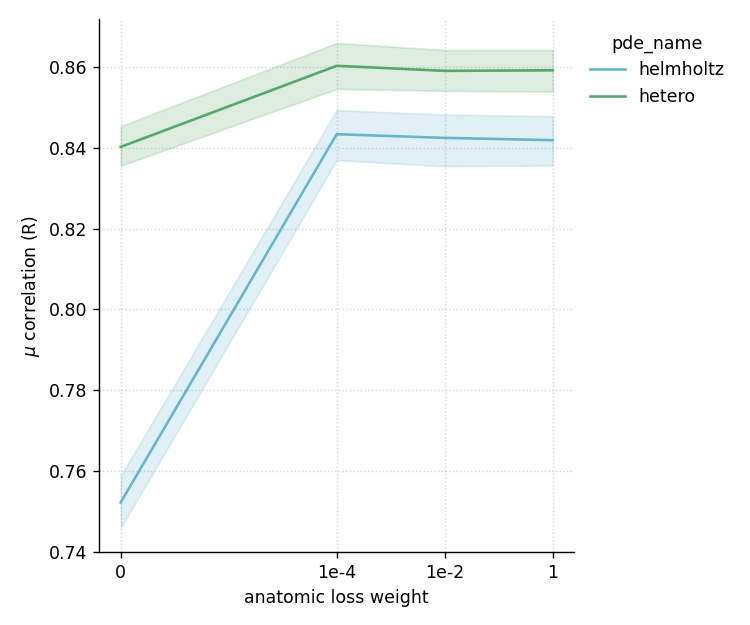

In [32]:
mm['mu_pred_R2'] = mm['mu_pred_R']**2

sns.set_palette(colors[-2:])

fig = ps.plot(
    mm[mm.spatial_region.isin({'all'}) & mm.spatial_frequency_bin.isin({'all'}) & mm.method.str.startswith('PINN')], 
    x='a_loss_weight_mod',
    y='mu_pred_R',
    hue='pde_name',
    height=5,
    width=6,
    legend=True,
    tight=True,
    plot_func=sns.lineplot
)
fig.axes[0].set_ylabel('$\mu$ correlation (R)')
fig.axes[0].set_xlabel('anatomic loss weight')
fig.axes[0].set_xscale('log')
fig.axes[0].set_xticks([1e-8, 1e-4, 1e-2, 1e0])
fig.axes[0].set_xticklabels(['0', '1e-4', '1e-2', '1'])
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_anat_bar_plot.{ext}', bbox_inches='tight', dpi=200)

In [62]:
# descriptive stats
mm[
    mm.spatial_region.isin({'all'}) &
    mm.spatial_frequency_bin.isin({'all'}) &
    ~mm.method.str.startswith('PINN')
] \
    .groupby(['pde_name', 'method'])[['mu_pred_R']].describe()

mu_pred_R                                                    \
                      count      mean       std       min       25%       50%   
pde_name  method                                                                
helmholtz AHI         613.0  0.567033  0.182800  0.006629  0.553346  0.631414   
          FEM-HH      605.0  0.679297  0.084248  0.448210  0.630801  0.702771   
hetero    FEM-het     611.0  0.675474  0.145108  0.255190  0.594697  0.736643   

                                       
                        75%       max  
pde_name  method                       
helmholtz AHI      0.670902  0.724919  
          FEM-HH   0.743749  0.834628  
hetero    FEM-het  0.783431  0.868569

In [34]:
# descriptive stats
mm[
    mm.spatial_region.isin({'all'}) &
    mm.spatial_frequency_bin.isin({'all'}) &
    mm.method.str.startswith('PINN')
] \
    .groupby(['pde_name', 'a_loss_weight'])[['mu_pred_R']].describe()

mu_pred_R                                          \
                            count      mean       std       min       25%   
pde_name  a_loss_weight                                                     
helmholtz 0.0000            155.0  0.752165  0.040121  0.576805  0.728400   
          0.0001            154.0  0.843386  0.039254  0.718338  0.821607   
          0.0100            154.0  0.842472  0.040483  0.720549  0.819936   
          1.0000            150.0  0.841910  0.040333  0.684437  0.817634   
hetero    0.0000            155.0  0.840237  0.031948  0.675076  0.821483   
          0.0001            154.0  0.860326  0.034629  0.752495  0.837541   
          0.0100            155.0  0.859077  0.034482  0.773236  0.833469   
          1.0000            155.0  0.859213  0.033058  0.780760  0.835781   

                                                       
                              50%       75%       max  
pde_name  a_loss_weight                                
helmholtz 0.0000         0.755523  0.779048  0.847216  
          0.0001         0.849677  0.871976  0.911119  
          0.0100         0.851879  0.874019  0.914914  
          1.0000         0.851468  0.872231  0.914003  
hetero    0.0000         0.843804  0.862318  0.902726  
          0.0001         0.866877  0.886468  0.917543  
          0.0100         0.865769  0.885963  0.917287  
          1.0000         0.867784  0.884524  0.919423

In [59]:
# two-sample t tests
from scipy.stats import ttest_ind, ttest_rel

for pde_name, df in mm[
    mm.spatial_region.isin({'all'}) &
    mm.spatial_frequency_bin.isin({'all'}) &
    mm.method.str.startswith('PINN')
].groupby('pde_name'):
    print(pde_name)
    
    df = df.set_index('example_id')
    sample1 = df[df.a_loss_weight == 1e-4]
    sample2 = df[df.a_loss_weight == 0]
    sample1 = sample1.loc[sample1.index.intersection(sample2.index)]
    sample2 = sample2.loc[sample1.index.intersection(sample2.index)]
    diff = sample1.mu_pred_R - sample2.mu_pred_R
    res = ttest_rel(sample1.mu_pred_R, sample2.mu_pred_R, alternative='greater')
    print(diff.describe())
    print(res)
    
    
    sample1 = df[df.a_loss_weight == 1e-2]
    sample2 = df[df.a_loss_weight == 1e-4]
    sample1 = sample1.loc[sample1.index.intersection(sample2.index)]
    sample2 = sample2.loc[sample1.index.intersection(sample2.index)]
    diff = sample1.mu_pred_R - sample2.mu_pred_R
    res = ttest_rel(sample1.mu_pred_R, sample2.mu_pred_R, alternative='two-sided')
    print(diff.describe())
    print(res)
    
    sample1 = df[df.a_loss_weight == 1e-2]
    sample2 = df[df.a_loss_weight == 1]
    sample2 = df[df.a_loss_weight == 1e-4]
    sample1 = sample1.loc[sample1.index.intersection(sample2.index)]
    sample2 = sample2.loc[sample1.index.intersection(sample2.index)]
    diff = sample1.mu_pred_R - sample2.mu_pred_R
    res = ttest_rel(sample1.mu_pred_R, sample2.mu_pred_R, alternative='two-sided')
    print(diff.describe())
    print(res)

helmholtz
count    154.000000
mean       0.091299
std        0.045457
min       -0.011665
25%        0.059997
50%        0.088211
75%        0.119323
max        0.218406
Name: mu_pred_R, dtype: float64
Ttest_relResult(statistic=24.924232035607677, pvalue=4.851320278250981e-56)
count    153.000000
mean      -0.000785
std        0.014637
min       -0.057160
25%       -0.009481
50%       -0.000554
75%        0.008905
max        0.035689
Name: mu_pred_R, dtype: float64
Ttest_relResult(statistic=-0.6632415846271384, pvalue=0.5081804432006842)
count    153.000000
mean      -0.000785
std        0.014637
min       -0.057160
25%       -0.009481
50%       -0.000554
75%        0.008905
max        0.035689
Name: mu_pred_R, dtype: float64
Ttest_relResult(statistic=-0.6632415846271384, pvalue=0.5081804432006842)
hetero
count    154.000000
mean       0.020055
std        0.030090
min       -0.066858
25%       -0.001615
50%        0.017104
75%        0.035012
max        0.124471
Name: mu_pred_R, dtype:

In [49]:
sample2.mu_pred_R

13325    0.863376
13273    0.866241
13481    0.868713
13377    0.804123
13429    0.865959
           ...   
10569    0.850126
10517    0.894240
10673    0.878787
10725    0.919423
10621    0.848985
Name: mu_pred_R, Length: 155, dtype: float64

<IPython.core.display.Javascript object>


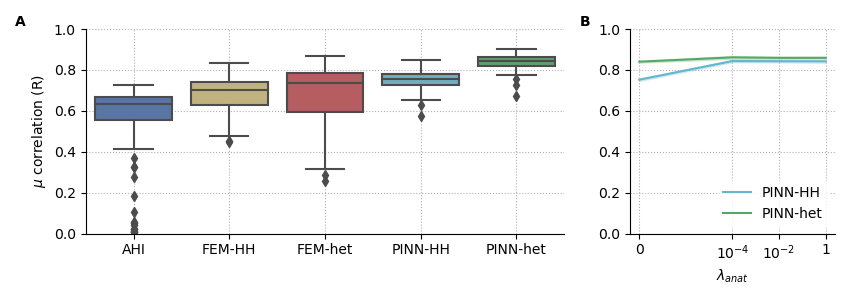

In [309]:
%autoreload
fig, ax = plt.subplots(1, 2, figsize=(8.5, 3), width_ratios=(0.7, 0.3), squeeze=False)

sns.set_palette(colors)
sns.boxplot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all') & mm.a_loss_weight == 0],
    x='method',
    y='mu_pred_R',
    ax=ax[0,0]
)
ax[0,0].grid(linestyle=':')
ax[0,0].axes.set_axisbelow(True)

t = mpl.transforms.ScaledTranslation(-0.6, 0, fig.dpi_scale_trans)
ax[0,0].text(
    0, 1, 'A', fontweight='bold', va='bottom', ha='right',
    transform=ax[0,0].transAxes + t
)

ax[0,0].set_ylabel('$\mu$ correlation (R)')
ax[0,0].set_ylim(0, 1.0)
ax[0,0].set_xlabel(None)
ax[0,0].set_xticklabels([t.get_text().replace('_', '_\n') for t in ax[0,0].get_xticklabels()])

sns.set_palette(colors[-2:])
sns.lineplot(
    mm[(mm.spatial_region == 'all') & (mm.spatial_frequency_bin == 'all') & mm.method.str.startswith('PINN')],
    x='a_loss_weight_mod',
    y='mu_pred_R',
    hue='method',
    errorbar='ci',
    ax=ax[0,1]
)
ax[0,1].legend(frameon=True, loc='lower right', edgecolor='w')
ax[0,1].grid(linestyle=':')
ax[0,1].axes.set_axisbelow(True)

t = mpl.transforms.ScaledTranslation(-0.4, 0, fig.dpi_scale_trans)
ax[0,1].text(0, 1, 'B', fontweight='bold', va='bottom', ha='right', transform=ax[0,1].transAxes + t)

ax[0,1].set_ylabel(None)
ax[0,1].set_ylim(0, 1)
ax[0,1].set_xlabel('$\lambda_{anat}$')
ax[0,1].set_xscale('log')
ax[0,1].set_xticks([1e-8, 1e-4, 1e-2, 1e0])
ax[0,1].set_xticklabels(['0'] + ax[0,1].get_xticklabels()[1:-1] + ['1'])

sns.despine(fig)
fig.tight_layout()

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_plots.{ext}', bbox_inches='tight', dpi=200)

In [360]:
%autoreload

blue, orange, green, red, purple, brown, pink, gray, yellow, cyan = sns.color_palette('tab10')

mre_pinn.visual.COLORS.update(
    red=red,
    yellow=yellow,
    green=green,
    cyan=cyan,
    blue=blue,
    purple=purple
)

In [ ]:
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v3', '0006', anat=True)
example.arrays['anat'] = example.anat.sel(z=0.018237183332, method='nearest')

<IPython.core.display.Javascript object>


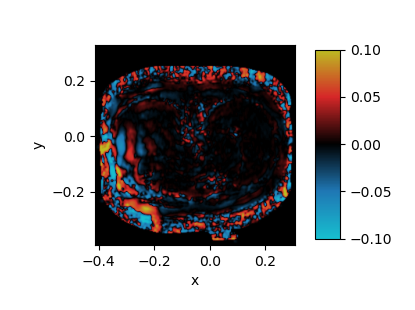

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



<IPython.core.display.Javascript object>


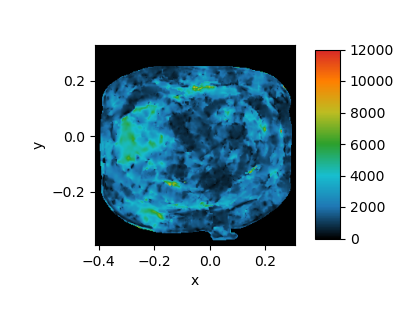

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

  plt.gcf().tight_layout()



In [367]:
%autoreload

wave_kws = dict(vmin=-1e-1, vmax=1e-1, cmap=mre_pinn.visual.wave_color_map())
elast_kws = dict(vmin=0, vmax=12e3, cmap=mre_pinn.visual.mre_color_map(symmetric=False))

#example.view('anat', ax_height=2, space=0.2)
#plt.gcf().tight_layout()
#plt.savefig('images/patient_anat.png', dpi=200, bbox_inches='tight')

example.view('wave', ax_height=2, space=0.2, **wave_kws)
plt.gcf().tight_layout()
plt.savefig('images/patient_wave.png', dpi=200, bbox_inches='tight')

example.view('mre', ax_height=2, space=0.2, **elast_kws)
plt.gcf().tight_layout()
plt.savefig('images/patient_mre.png', dpi=200, bbox_inches='tight')

<IPython.core.display.Javascript object>


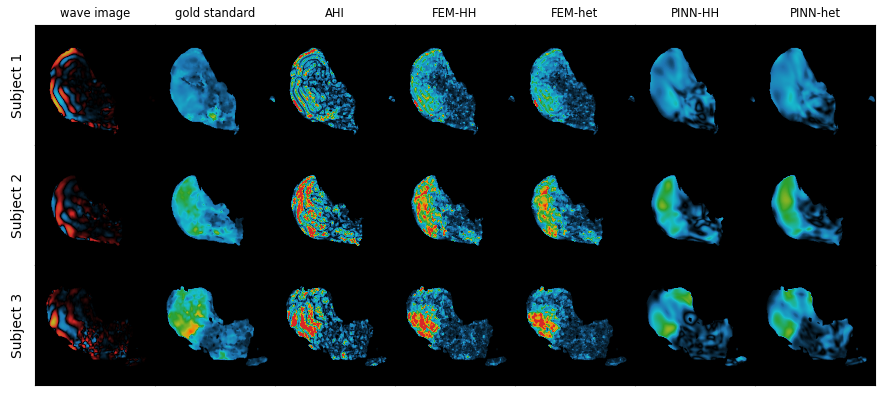

Loading ../data/NAFLD/v4/1337/wave.nc
Loading ../data/NAFLD/v4/1337/mre.nc
Loading ../data/NAFLD/v4/1337/mre_mask.nc
Loading 2023-2-28_patient_anat3/train_patient_1337_30_helmholtz_1e-02/train_patient_1337_30_helmholtz_1e-02_direct.nc
Loading 2023-2-28_patient_anat3/train_patient_1337_30_helmholtz_1e-02/train_patient_1337_30_helmholtz_1e-02_fem.nc
Loading 2023-3-2_patient_anat/train_patient_1337_30_hetero_1e-02/train_patient_1337_30_hetero_1e-02_fem.nc
Loading 2023-2-28_patient_anat3/train_patient_1337_30_helmholtz_1e-02/train_patient_1337_30_helmholtz_1e-02_elastogram.nc
Loading 2023-3-2_patient_anat/train_patient_1337_30_hetero_1e-02/train_patient_1337_30_hetero_1e-02_elastogram.nc
Loading ../data/NAFLD/v4/1039/wave.nc
Loading ../data/NAFLD/v4/1039/mre.nc
Loading ../data/NAFLD/v4/1039/mre_mask.nc
Loading 2023-2-28_patient_anat3/train_patient_1039_30_helmholtz_1e-02/train_patient_1039_30_helmholtz_1e-02_direct.nc
Loading 2023-2-28_patient_anat3/train_patient_1039_30_helmholtz_1e-02/tr

In [415]:
%autoreload
import mre_pinn

image_names = [
    'wave image', 'gold standard', 'AHI', 'FEM-HH', 'FEM-het', 'PINN-HH', 'PINN-het'
]

expt_name1 = '2023-2-28_patient_anat3' # Helmholtz
expt_name2 = '2023-3-2_patient_anat'   # hetero
name = 'train_patient_{example_id}_{omega}_{pde_name}_{a_loss_weight:.0e}'

def plot_image_grid(example_ids):
    n_rows = len(example_ids)
    n_cols = len(image_names)
    ax_width = 1.2
    ax_height = ax_width
    
    omega = 30
    a_loss_weight = 1e-2
    savgol_filter = 0

    fig, axes, cbar_ax = mre_pinn.visual.subplot_grid(
        n_rows, n_cols, ax_height, ax_width, space=0, pad=(0.35,0.15,0.15,0.25)
    )
    for row_idx, example_id in enumerate(example_ids):
        example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v4', example_id)
        z = example.mre.z[0]
        for col_idx, image_name in enumerate(image_names):
            ax = axes[row_idx,col_idx]
            #ax.text(0.1, 0.1, f'{row_idx}, {col_idx}')
            if col_idx == 0:
                ax.set_ylabel(f'Subject {row_idx+1}', fontsize='medium')
            if row_idx == 0:
                ax.set_title(image_name, fontsize='small')
            ax.set_yticks([])
            ax.set_xticks([])

            if image_name == 'wave image':
                array = example.wave[...,0]
                color_kws = wave_kws
                array = array.real * (example.mre_mask.values[...,0] > 0)

            elif image_name in {'ground truth', 'gold standard'}:
                array = example.mre[...,0]
                color_kws = elast_kws
                array = np.abs(array) * (example.mre_mask.values[...,0] > 0)

            elif image_name == 'AHI':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{expt_name1}/{job_name}/{job_name}_direct.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='direct_pred', z=z)
                color_kws = elast_kws
                array = np.abs(array)
                
            elif image_name == 'FEM-HH':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{expt_name1}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=z)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'FEM-het':
                job_name = name.format(
                    example_id=example_id, pde_name='hetero', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{expt_name2}/{job_name}/{job_name}_fem.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='fem_pred', z=z)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-HH':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{expt_name1}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=z)
                color_kws = elast_kws
                array = np.abs(array)

            elif image_name == 'PINN-het':
                job_name = name.format(
                    example_id=example_id, pde_name='hetero', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{expt_name2}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=z)
                color_kws = elast_kws
                array = np.abs(array)
                
            elif image_name == 'PINN-HH-anat':
                job_name = name.format(
                    example_id=example_id, pde_name='helmholtz', omega=omega, a_loss_weight=a_loss_weight
                )
                nc_file = f'{pinn_expt_name}/{job_name}/{job_name}_elastogram.nc'
                array = mre_pinn.data.dataset.load_xarray_file(nc_file).sel(variable='mu_pred', z=z)
                color_kws = elast_kws
                array = np.abs(array)

            mre_pinn.visual.imshow(ax, array[15:-44,23:-36], **color_kws)
    
    return fig

#fig0 = plot_image_grid(['0006', '0020', '0024', '0029'])
#fig1 = plot_image_grid(['0043', '0047', '0126', '0135'])
#fig = plot_image_grid(['2029', '1948', '1940', '1839', '1791', '1671', '1448', '1435', '1045', '1039'])
fig = plot_image_grid(['1337', '1039', '0659'])

for ext in ['png', 'pdf']:
    fig.savefig(f'images/patient_image_grid.{ext}', bbox_inches='tight', dpi=200)
    pass

In [ ]:
example = mre_pinn.data.MREExample.load_xarrays('../data/NAFLD/v3', '0006')
example.view()

In [ ]:
import xarray as xr
u = example.wave
x = u.field.points(reshape=False)
x = (x - x.mean(axis=(0,1,2), keepdims=True)) / (x.max(axis=(0,1,2), keepdims=True) - x.min(axis=(0,1,2), keepdims=True))
x, y, z = x[...,0], x[...,1], x[...,2]
r = np.sqrt(x**2 + y**2)
sin = y / (r + 1e-3)
cos = x / (r + 1e-3)
x = np.stack([x, y, z, r, sin, cos], axis=-1)

print(x.shape)
x_dims = ['x', 'y', 'z', 'component']
x_coords = {
    'x': u.x,
    'y': u.y,
    'z': u.z,
    'component': ['x', 'y', 'z', 'r', 'sin', 'cos']
}
x = xr.DataArray(x, coords=x_coords, dims=x_dims)
x.name = 'position'
mre_pinn.visual.XArrayViewer(x, ax_height=3)

In [ ]:
example.wave.coords